# Airbnb Project

### Content
The following Airbnb activity is included in this Seattle dataset:

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Questions
- What are the most expensive neigbourhoods in Seattle ?
- How are the occupancies within the neighbourhoods in Seattle ?
- Pricing model: Can I perform a prognose of the price of the apartment based on location, properties (frunishment, rooms, sqm, etc.), time, ... ?

### Import of libraries & data

In [310]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", None)

# Import files:
df_calendar = pd.read_csv("./data/archive/calendar.csv")
df_listings = pd.read_csv("./data/archive/listings.csv")
df_reviews = pd.read_csv("./data/archive/reviews.csv")

# Check rows x columns of data:
print("df_listings:" + str(df_listings.shape))
print("df_calendar:" + str(df_calendar.shape))
print("df_reviews:" + str(df_reviews.shape))
print("-------------")

df_listings:(3818, 92)
df_calendar:(1393570, 4)
df_reviews:(84849, 6)
-------------


### Data cleaning and structuring

In [314]:
# Rename columns:
df_listings.rename(columns={"id": "listing_id"}, inplace=True)
df_listings.rename(columns={"price": "price_room"}, inplace=True)

# Create list of dfs to integrate in future loops:
df_vec = [df_calendar, df_listings, df_reviews]

# Convert date columns to datetime-type:
df_calendar["date"] = pd.to_datetime(df_calendar["date"], format='%Y-%m-%d')
df_listings["host_since"] = pd.to_datetime(df_listings["host_since"], format='%Y-%m-%d')

# Converting the %-Values from String to Float:
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(str).str.replace('%', '').str.replace(',', '').astype(float)
df_listings["host_acceptance_rate"] = df_listings["host_acceptance_rate"].astype(str).str.replace('%', '').str.replace(',', '').astype(float)

# Converting the $-Values from String to Float:
df_calendar["price"] = df_calendar["price"].astype(str).str.replace("$", "").str.replace(",", "").astype(float)
dollars = ["price_room", "security_deposit", "cleaning_fee", "extra_people"]
for dollar in dollars:
    df_listings[dollar] = df_listings[dollar].astype(str).str.replace("$", "").str.replace(",", "").astype(float)

# Separation into relevant numeric and categoric data:
df_cal_list_num = df_listings[["accommodates", "number_of_reviews", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "bathrooms", "bedrooms", "beds", "guests_included", "minimum_nights", "maximum_nights", "security_deposit", "cleaning_fee", "extra_people", "host_response_rate", "host_acceptance_rate"]]
df_cal_list_cat = df_listings[["listing_id", "cancellation_policy", "neighbourhood", "host_identity_verified", "host_has_profile_pic", "property_type", "room_type", "bed_type", "cancellation_policy", "require_guest_profile_picture", "require_guest_phone_verification", "instant_bookable", "host_response_time", "host_is_superhost"]]

# Combination of num and cat variables to whole df_new of the calendar df:
df_new = pd.concat([df_cal_list_num, df_cal_list_cat], axis =1)

# Combination of "relevant" listing and calendar df:
df_new = pd.merge(df_new, df_calendar, on='listing_id', how='left')

df_new.head()

,accommodates,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,security_deposit,cleaning_fee,extra_people,host_response_rate,host_acceptance_rate,listing_id,cancellation_policy,neighbourhood,host_identity_verified,host_has_profile_pic,property_type,room_type,bed_type,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,instant_bookable,host_response_time,host_is_superhost,date,available,price
0,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-04,t,85.0
1,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-05,t,85.0
2,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-06,f,NaN
3,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-07,f,NaN
4,4,207,10.0,10.0,10.0,10.0,9.0,10.0,1.0,1.0,1.0,2,1,365,NaN,NaN,5.0,96.0,100.0,241032,moderate,Queen Anne,t,t,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,within a few hours,f,2016-01-08,f,NaN


### Correlation Heat Map
#### Let's look at how the "relevant" numeric parameters correlate with each other:

<Axes: >

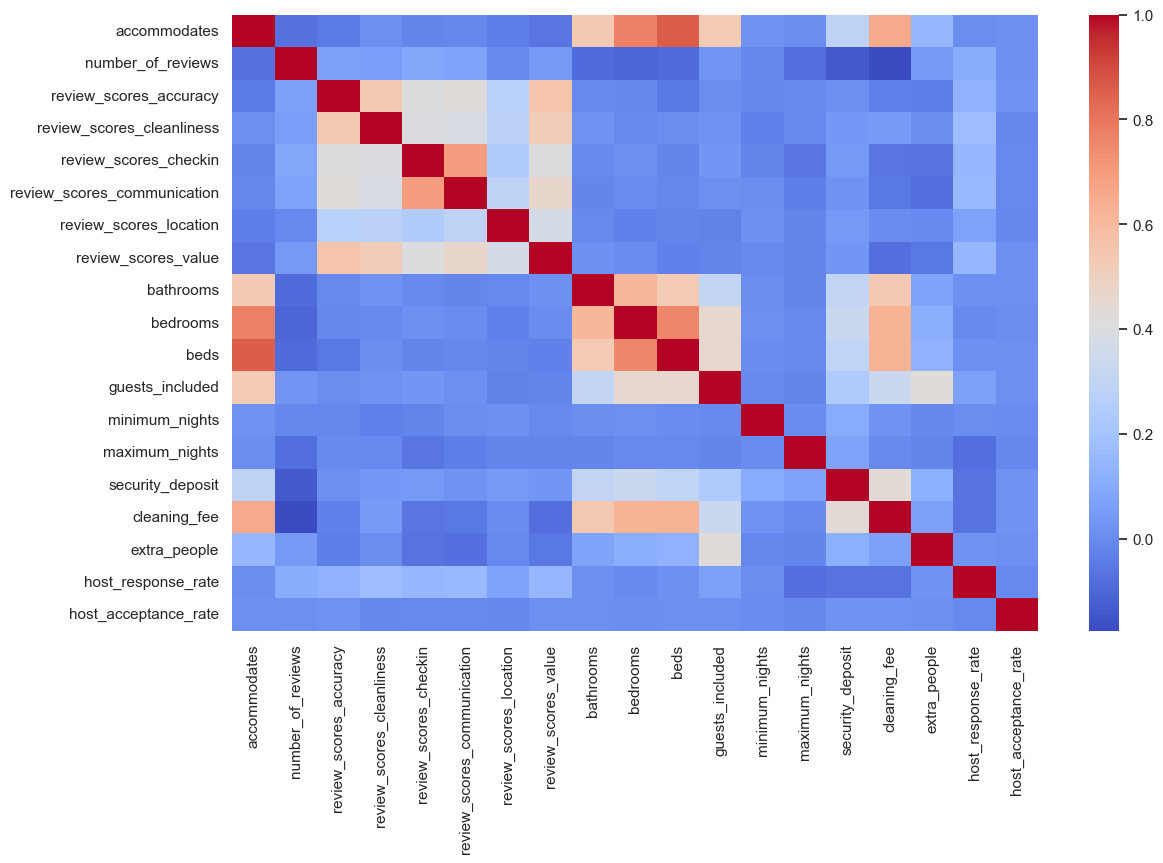

In [268]:
df_listings_corr_matrix = df_cal_list_num.corr()
sns.heatmap(df_listings_corr_matrix, cmap='coolwarm', fmt='.2f')

### Amount of Airbnbs per neighbourhood
#### Let's check how many different Airbnb-properties there are in each neighbourhood of Seattle:


In [270]:
unique_listing_counts = df_new.groupby("neighbourhood")["listing_id"].nunique().reset_index().sort_values(by="listing_id", ascending=False)

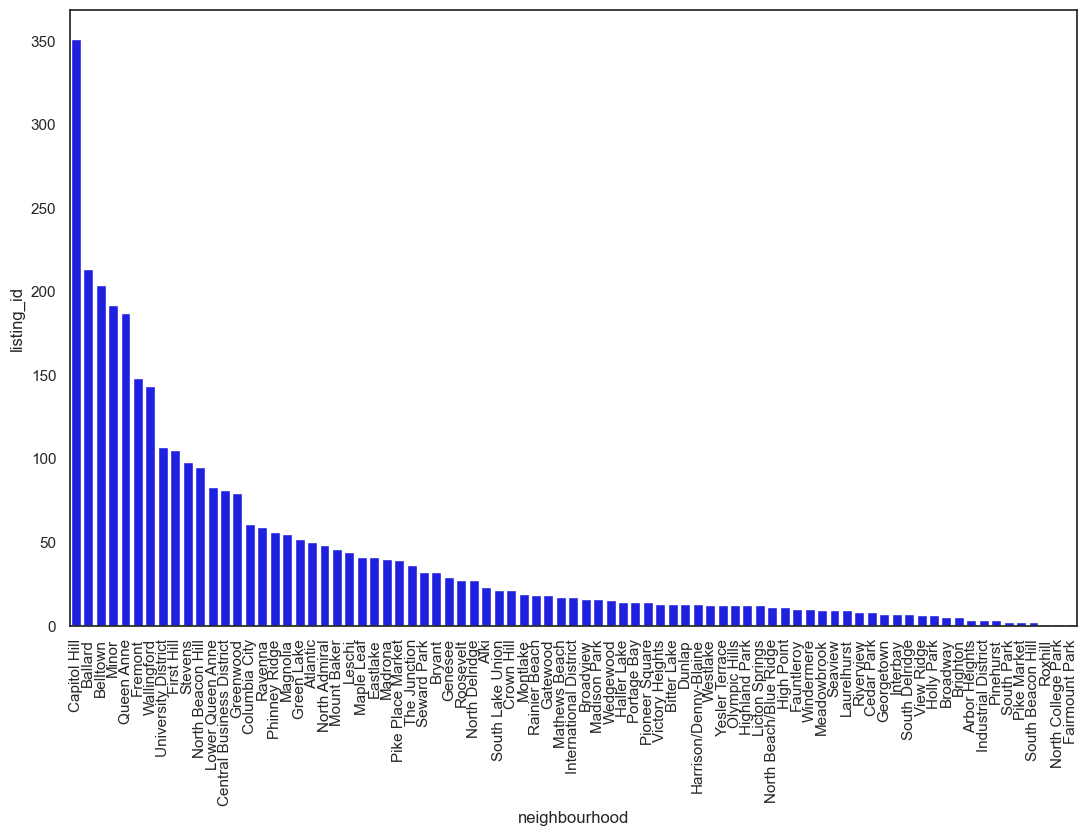

In [316]:
# Plotting the amount of airbnbs in each neighbourhood:
sns.set_theme(style="white", rc={"figure.figsize":(13,8)})
fig, ax = plt.subplots()
neighbourhood_amount_airbnbs = sns.barplot(x="neighbourhood", y="listing_id", data=unique_listing_counts, color="blue", ax=ax)
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_amount_airbnbs.set_xticklabels(neighbourhood_amount_airbnbs.get_xticklabels(), rotation=90);

#### How many neighbourhoods have less than 5 Airbnbs ?

In [274]:
excl_neighbourhoods = unique_listing_counts[unique_listing_counts["listing_id"] < 5]
excl_neighbourhoods = excl_neighbourhoods["neighbourhood"].tolist()

# Let's exclude those from further analysis
for neighbourhood in excl_neighbourhoods:
    df_new = df_new[df_new["neighbourhood"] != neighbourhood]

### Average Airbnb prices per neighbourhood
#### Now Let's look at average prices inside the neighbourhoods:

          neighbourhood       price
17       Fairmount Park  370.000000
58          Portage Bay  250.885285
31  Industrial District  245.875441
79           Windermere  227.516092
0                  Alki  226.410733
..                  ...         ...
30           Holly Park   78.184594
23           Georgetown   78.025107
62            Riverview   77.346276
52        Olympic Hills   66.256790
64              Roxhill   60.000000

[81 rows x 2 columns]
134.04049494717296


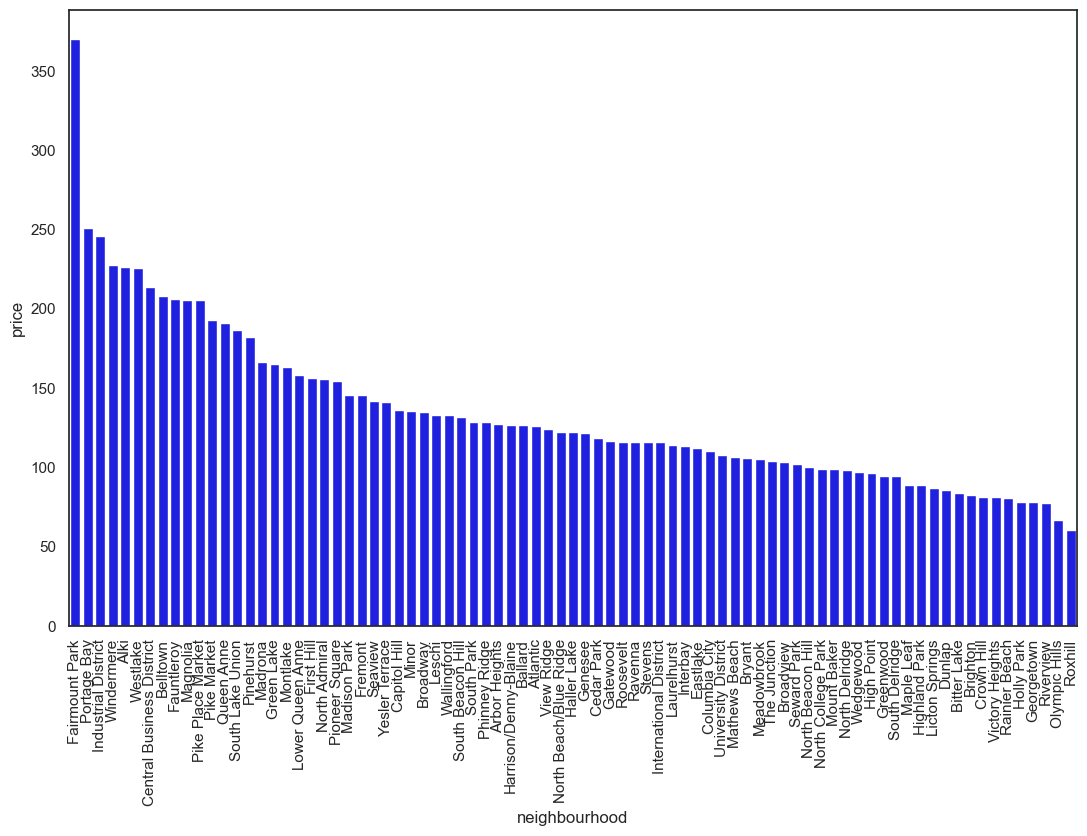

In [318]:
df_neighbourhood_prices = df_new[["neighbourhood", "price"]]
df_neighbourhood_prices = df_neighbourhood_prices.groupby("neighbourhood").mean().reset_index()
df_neighbourhood_prices = df_neighbourhood_prices.sort_values(by="price", ascending=False)
sns.set_theme(style="white", rc={"figure.figsize":(13,8)})
fig, ax = plt.subplots()
neighbourhood_prices = sns.barplot(x="neighbourhood", y="price", data=df_neighbourhood_prices, color="blue", ax=ax)
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_prices.set_xticklabels(neighbourhood_prices.get_xticklabels(), rotation=90);

print(df_neighbourhood_prices)
print(df_neighbourhood_prices["price"].mean())

### Average Airbnb occupancy rates per neighbourhood
#### Now Let's look at average monthly occupancy rate inside the neighbourhoods

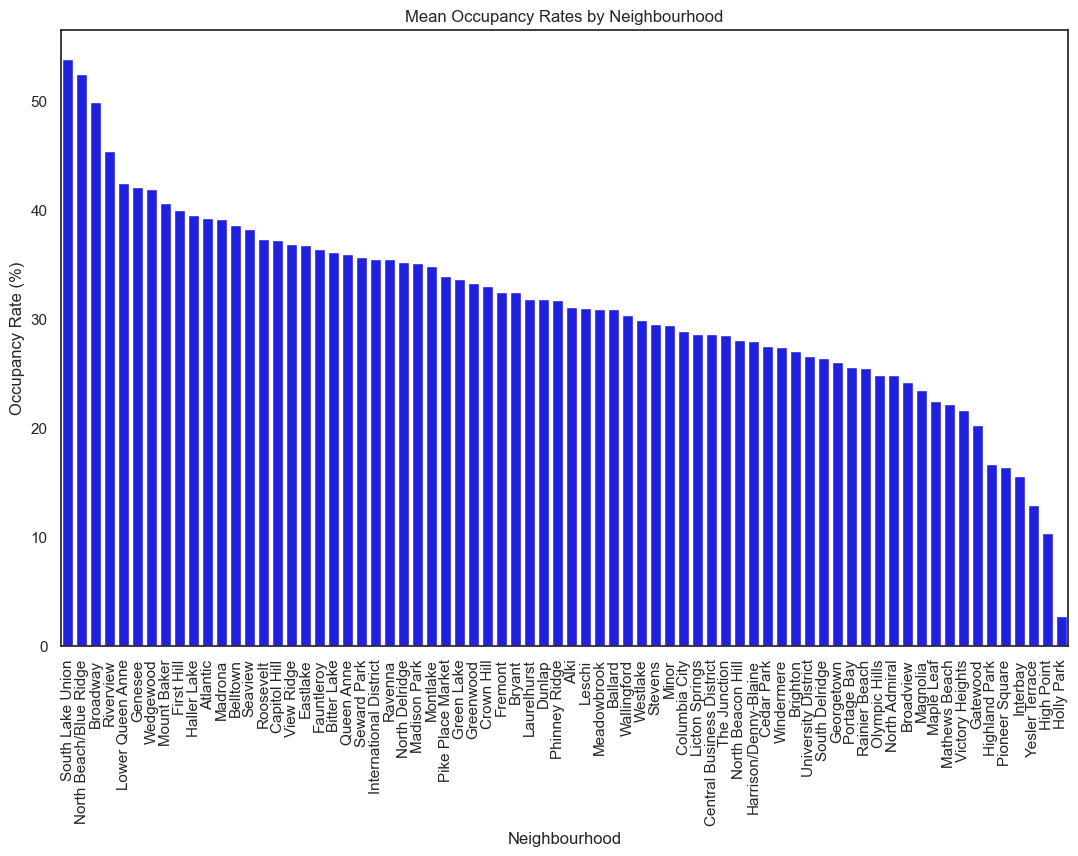

             neighbourhood  available
61        South Lake Union  53.804007
45  North Beach/Blue Ridge  52.448886
7                 Broadway  49.854617
56               Riverview  45.364197
34        Lower Queen Anne  42.419893
..                     ...        ...
51          Pioneer Square  16.329335
29                Interbay  15.530030
71          Yesler Terrace  12.895579
26              High Point  10.315572
28              Holly Park   2.673578

[72 rows x 2 columns]
31.21537350340423


In [280]:
# Calculate the mean occupancy rate per neighbourhood
df_monthly_occup_ratio = (
    df_new
    .groupby(["neighbourhood", pd.Grouper(key="date", freq="M")])["available"]
    .apply(lambda x: (1 - (x == "t").sum() / len(x)) * 100)
    .reset_index()
)

# Group and sort the values
df_neighbourhood_occup = df_monthly_occup_ratio.groupby("neighbourhood")["available"].mean().reset_index()
df_neighbourhood_occup = df_neighbourhood_occup.sort_values(by="available", ascending=False)

# Create the plot
sns.set_theme(style="white", rc={"figure.figsize":(13,8)})
fig, ax = plt.subplots()
neighbourhood_occup = sns.barplot(x="neighbourhood", y="available", data=df_neighbourhood_occup, color="blue", ax=ax)
ax.set_axisbelow(True)
ax.grid(False)
neighbourhood_occup.set_xticklabels(neighbourhood_occup.get_xticklabels(), rotation=90)
ax.set_title("Mean Occupancy Rates by Neighbourhood")
ax.set_xlabel("Neighbourhood")
ax.set_ylabel("Occupancy Rate (%)")
plt.show()

print(df_neighbourhood_occup)
print(df_neighbourhood_occup["available"].mean())

### Analysis of the mean price and occupancy over time

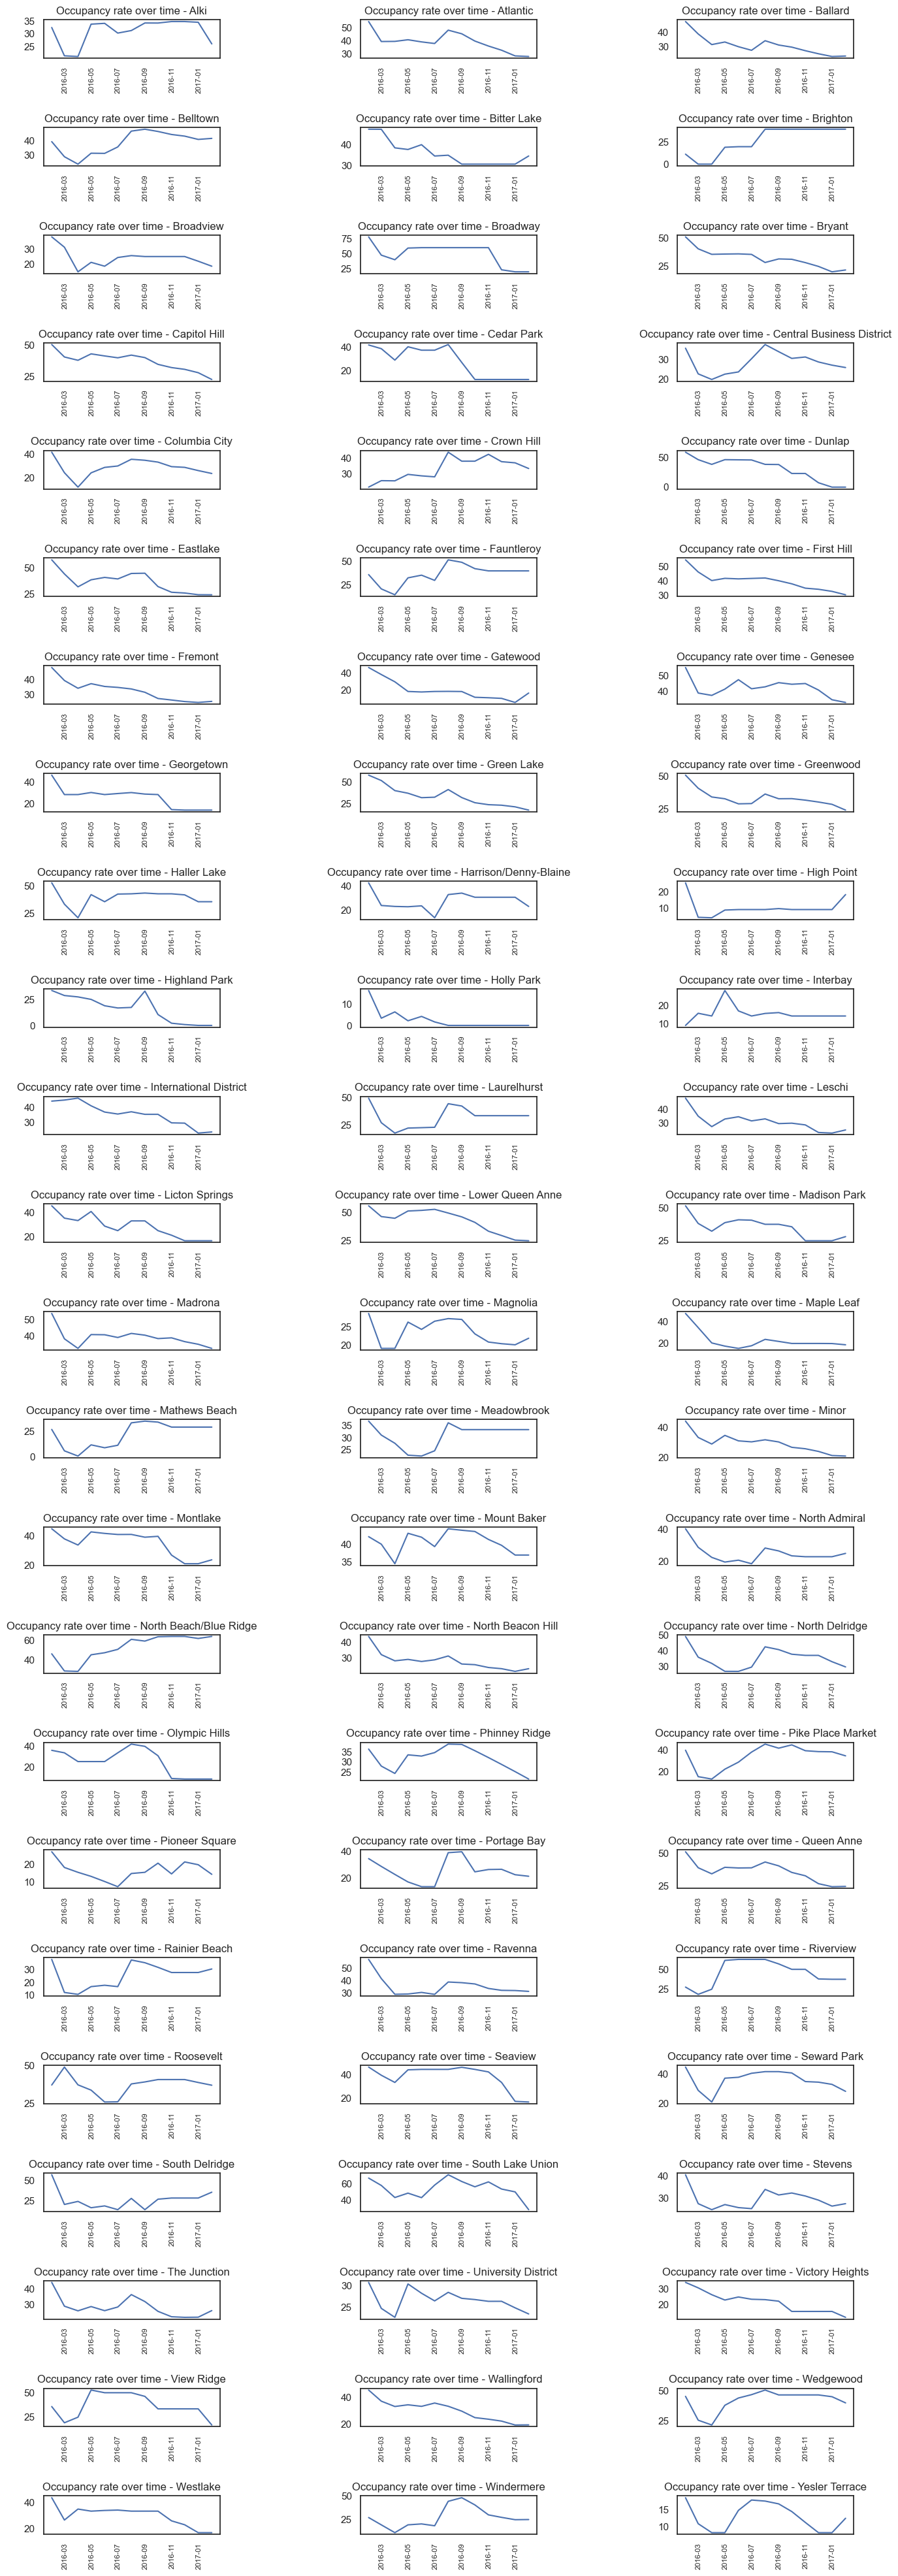

In [282]:
# Get the unique neighbourhoods
neighbourhoods = df_monthly_occup_ratio["neighbourhood"].unique()

# Calculate the number of rows and columns for the grid layout
num_plots = len(neighbourhoods)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create a figure with grid layout
fig = plt.figure(figsize=(16, 50))
gs = fig.add_gridspec(num_rows, num_cols, wspace=0.8, hspace=1.8)

# Loop through the neighbourhoods and plot the occupancy rate
for i, neighbourhood in enumerate(neighbourhoods):
    ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
    df_occup = df_monthly_occup_ratio[df_monthly_occup_ratio["neighbourhood"] == neighbourhood]
    ax.plot(df_occup["date"], df_occup["available"])
    ax.set_title(f"Occupancy rate over time - {neighbourhood}")
    ax.tick_params(axis="x", which="major", rotation=90, labelsize=8)
plt.show()

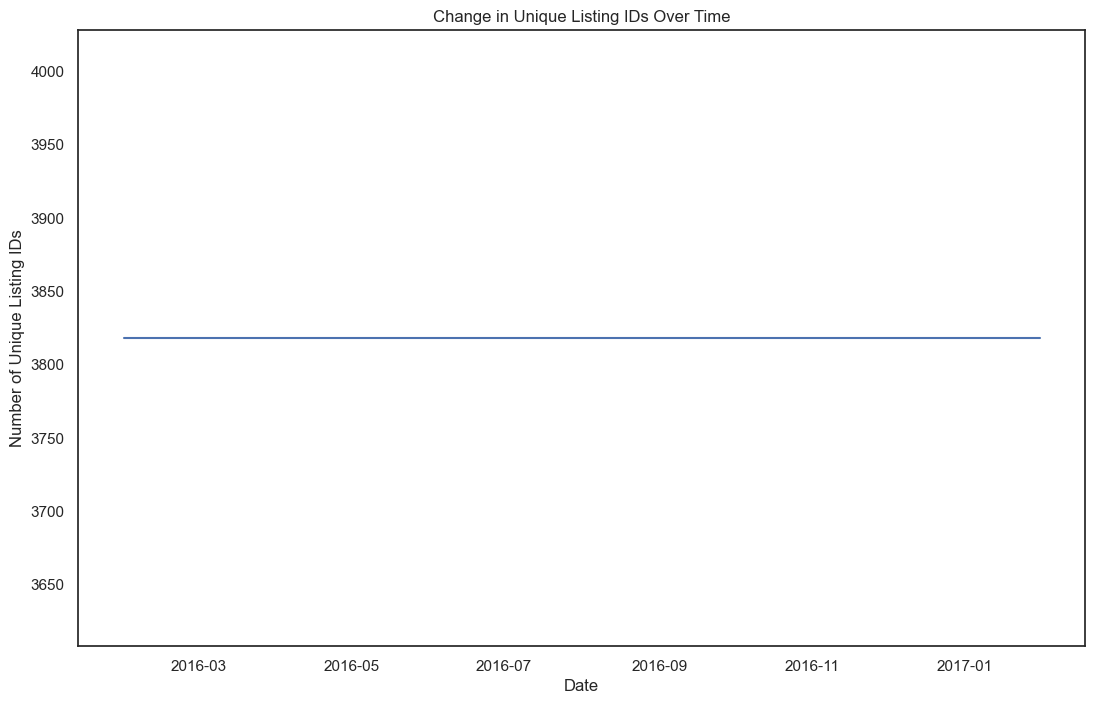

In [185]:
unique_listing_counts = df_calendar.resample('M', on='date')['listing_id'].nunique()
unique_listings_over_time

plt.plot(unique_listings_over_time.index, unique_listings_over_time.values)
plt.xlabel('Date')
plt.ylabel('Number of Unique Listing IDs')
plt.title('Change in Unique Listing IDs Over Time')
plt.show()

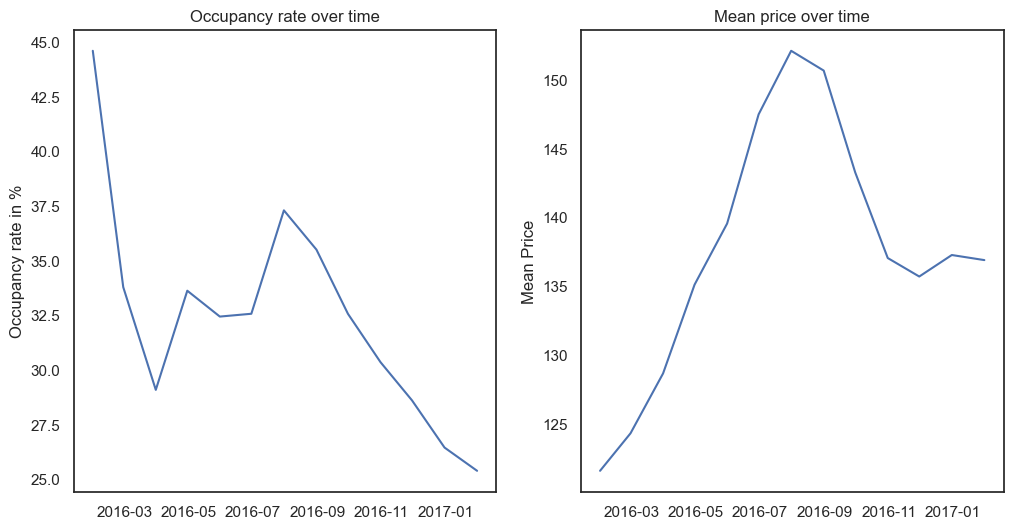

In [242]:
df_monthly_occup_ratio = df_calendar.resample("M", on="date")["available"].apply(lambda x: (1 - (x == "t").sum() / len(x)) * 100)
df_monthly_mean_price = df_calendar_t[["price","date"]].resample("M", on="date").mean()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_monthly_occup_ratio.index, df_monthly_occup_ratio.values)
plt.ylabel("Occupancy rate in %")
plt.title("Occupancy rate over time")

plt.subplot(1, 2, 2)
plt.plot(df_monthly_mean_price.index, df_monthly_mean_price["price"])
plt.ylabel("Mean Price")
plt.title("Mean price over time")

plt.show()

## Price prognosis via Linear Regression Model

In [289]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = df_cal_list_cat.columns

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [291]:
# Drop columns that are not needed for the linear regression model
df_new = df_new.drop(["date", "available", "listing_id"], axis=1)

# Drop NaN
df_new = df_new.dropna(subset=["price", "property_type", "beds", "bedrooms", "bathrooms"])

#Create dummies for categoric variables using the prior created function
df_new = create_dummy_df(df_new, df_cal_list_cat, dummy_na=False)

# Fill the mean (not applied, as dropping NaN-values makes more sense for the chosen data)
#fill_mean = lambda col: col.fillna(col.mean())
#df_new = df_new.apply(fill_mean, axis=0)

df_new = df_new.dropna()

#Split into explanatory and response variables
y = df_new.pop("price")
X = df_new

print(df_new.isnull().sum()/df_new.shape[0])

accommodates                             0.0
number_of_reviews                        0.0
review_scores_accuracy                   0.0
review_scores_cleanliness                0.0
review_scores_checkin                    0.0
                                        ... 
instant_bookable_t                       0.0
host_response_time_within a day          0.0
host_response_time_within a few hours    0.0
host_response_time_within an hour        0.0
host_is_superhost_t                      0.0
Length: 124, dtype: float64


In [293]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=1)

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.7284567709092991 on 92461 values.'